Runs two basic convolutional networks on the pilot dataset.

The regression modules are implemented in cs273b-project/dragonn

To make changes to this dragonn-

\$ sudo su

\$ source activate regression_dragonn

\$ cd cs273b-project/dragonn

\$ python setup.py install

In [1]:
from dragonn import models

from collections import OrderedDict
from pprint import pprint

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

Using Theano backend.
Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5005)
/usr/local/anaconda3/envs/regression_dragonn/lib/python2.7/site-packages/theano/tensor/signal/downsample.py:6: UserWarning: downsample module has been moved to the theano.tensor.signal.pool module.
  "downsample module has been moved to the theano.tensor.signal.pool module.")


Read in the pilot data.
- Samples are sequences that will be one hot encoded
- Try and predict the normalized values. **I couldn't figure out how to do regression with Dragonn, so I just rounded the values to 0 or 1 based on the median.**

In [2]:
key_to_seq = OrderedDict()

with open("../data/Pilot_counts_sequences/PilotDesign.sequences.txt") as f:
    for line in f:
        key, seq = line.strip().split()
        key_to_seq[key] = seq

In [3]:
key_to_normalized_K562_Rep1 = {}
key_to_normalized_K562_Rep2 = {}

with open("../data/Pilot_normalized/K562/tablenorm_recenterends_K562_Rep1_20.txt") as f:
    for line in f:
        parts = line.strip().split()
        
        for i, norm in enumerate(parts[1:]):
            key = "{}_{}".format(parts[0], i)
            val = float(norm)
            key_to_normalized_K562_Rep1[key] = val
            
with open("../data/Pilot_normalized/K562/tablenorm_recenterends_K562_Rep2_20.txt") as f:
    for line in f:
        parts = line.strip().split()
        
        for i, norm in enumerate(parts[1:]):
            key = "{}_{}".format(parts[0], i)
            val = float(norm)
            key_to_normalized_K562_Rep2[key] = val

# Check that the sequence and value keys line up.
assert set(key_to_normalized_K562_Rep1.keys()) == set(key_to_seq.keys())
assert set(key_to_normalized_K562_Rep2.keys()) == set(key_to_seq.keys())

In [4]:
# One hot encode DNA sequences the standard way.
def one_hot_encode_seq(seq):
    bases = ['A', 'T', 'C', 'G']
    # Gotta be ready for when we discover a new base.
    result = np.zeros((4, len(seq)))
    
    for i, base in enumerate(seq):
        result[bases.index(base), i] = 1

    return result

def seqs_to_encoded_matrix(seqs):
    # Wrangle the data into a shape that Dragonn wants.
    result = np.concatenate(
        map(one_hot_encode_seq, seqs)
    ).reshape(
        len(seqs), 1, 4, len(seqs[0])
    )
    
    # Check we actually did the encoding right.
    for i in range(len(seqs)):
        for j in range(len(seqs[0])):
            assert sum(result[i, 0, :, j]) == 1
    
    return result

In [5]:
X = seqs_to_encoded_matrix(key_to_seq.values())

In [6]:
K562_Rep1_y = np.array(
    map(
        lambda key: key_to_normalized_K562_Rep1[key], 
        key_to_seq.keys()
    )
).reshape(-1, 1)

K562_Rep2_y = np.array(
    map(
        lambda key: key_to_normalized_K562_Rep2[key], 
        key_to_seq.keys()
    )
).reshape(-1, 1)

y = (K562_Rep1_y + K562_Rep2_y)/2

In [7]:
# Just take the last 100 to be the validation set.
X_train = X[:-100,:,:,:]
y_train = y[:-100,:]

X_valid = X[-100:,:,:,:]
y_valid = y[-100:,:]

Basic regression model that optimizes for RMS error using RMSProp. Train and plot the train and validation loss.

In [8]:
model = models.SequenceDNN_Regression(
    seq_length=X_train.shape[3],
    num_filters=[1],
    conv_width=[45],
    pool_width=45,
    num_tasks=y_train.shape[1]
)

In [9]:
model.train(X_train, y_train, (X_valid, y_valid))

Training model (* indicates new best result)...
Epoch 1:
Train Mean Squared Error: 1.5542	Mean Absolute Error: 0.8483	 Median Absolute Error: 0.5422	 R2 Score: 0.0007
Valid Mean Squared Error: 2.3232	Mean Absolute Error: 1.1056	 Median Absolute Error: 0.6395	 R2 Score: -0.0169 *
Epoch 2:
Train Mean Squared Error: 1.5507	Mean Absolute Error: 0.8490	 Median Absolute Error: 0.5459	 R2 Score: 0.0030
Valid Mean Squared Error: 2.3210	Mean Absolute Error: 1.1057	 Median Absolute Error: 0.6492	 R2 Score: -0.0160 *
Epoch 3:
Train Mean Squared Error: 1.5475	Mean Absolute Error: 0.8484	 Median Absolute Error: 0.5413	 R2 Score: 0.0050
Valid Mean Squared Error: 2.3182	Mean Absolute Error: 1.1048	 Median Absolute Error: 0.6509	 R2 Score: -0.0148 *
Epoch 4:
Train Mean Squared Error: 1.5448	Mean Absolute Error: 0.8479	 Median Absolute Error: 0.5401	 R2 Score: 0.0068
Valid Mean Squared Error: 2.3154	Mean Absolute Error: 1.1038	 Median Absolute Error: 0.6494	 R2 Score: -0.0135 *
Epoch 5:
Train Mean Squa

In [10]:
def print_loss(model, metric):
    train_losses, valid_losses = [np.array([epoch_metrics[metric] for epoch_metrics in metrics])
                                  for metrics in (model.train_metrics, model.valid_metrics)]

    # Pretty sure early stopping works by taking the mean of losses, might want to double check
    train_losses = train_losses.mean(axis=1)
    valid_losses = valid_losses.mean(axis=1)

    f = plt.figure(figsize=(10, 4))
    ax = f.add_subplot(1, 1, 1)
    
    ax.plot(range(len(train_losses)), train_losses, label='Training',lw=4)
    ax.plot(range(len(train_losses)), valid_losses, label='Validation', lw=4)
    
    min_loss_indx = min(enumerate(valid_losses), key=lambda x: x[1])[0]
#     ax.plot([min_loss_indx, min_loss_indx], [0, 1.0], 'k--', label='Early Stop')
    ax.legend(loc="best")
    ax.set_ylabel(metric)
#     ax.set_ylim((-1.0,1.0))
    ax.set_xlabel("Epoch")
    plt.show()

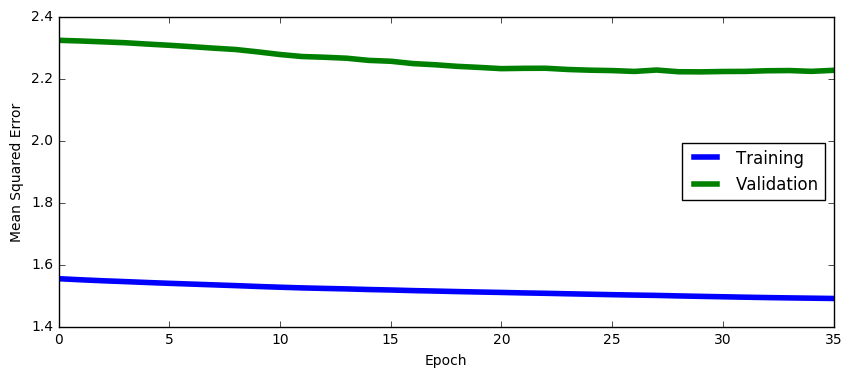

In [11]:
metric = "Mean Squared Error"
print_loss(model, metric)

Train and test on the multi-filter model used in the tutorial.

In [12]:
multi_filter_model = models.SequenceDNN_Regression(
    seq_length=X_train.shape[3],
    num_filters=[50],
    conv_width=[60],
    pool_width=45,
    num_epochs=1000,
    dropout=0.1,
    num_tasks=y_train.shape[1]
)

In [13]:
multi_filter_model.train(X_train, y_train, (X_valid, y_valid))

Training model (* indicates new best result)...
Epoch 1:
Train Mean Squared Error: 1.5305	Mean Absolute Error: 0.8389	 Median Absolute Error: 0.5293	 R2 Score: 0.0160
Valid Mean Squared Error: 2.2759	Mean Absolute Error: 1.0870	 Median Absolute Error: 0.6291	 R2 Score: 0.0038 *
Epoch 2:
Train Mean Squared Error: 1.5059	Mean Absolute Error: 0.8205	 Median Absolute Error: 0.4970	 R2 Score: 0.0318
Valid Mean Squared Error: 2.2462	Mean Absolute Error: 1.0688	 Median Absolute Error: 0.5810	 R2 Score: 0.0168 *
Epoch 3:
Train Mean Squared Error: 1.4858	Mean Absolute Error: 0.7975	 Median Absolute Error: 0.4446	 R2 Score: 0.0447
Valid Mean Squared Error: 2.2140	Mean Absolute Error: 1.0424	 Median Absolute Error: 0.5237	 R2 Score: 0.0309 *
Epoch 4:
Train Mean Squared Error: 1.4740	Mean Absolute Error: 0.7854	 Median Absolute Error: 0.4248	 R2 Score: 0.0523
Valid Mean Squared Error: 2.1917	Mean Absolute Error: 1.0283	 Median Absolute Error: 0.5300	 R2 Score: 0.0406 *
Epoch 5:
Train Mean Squared 

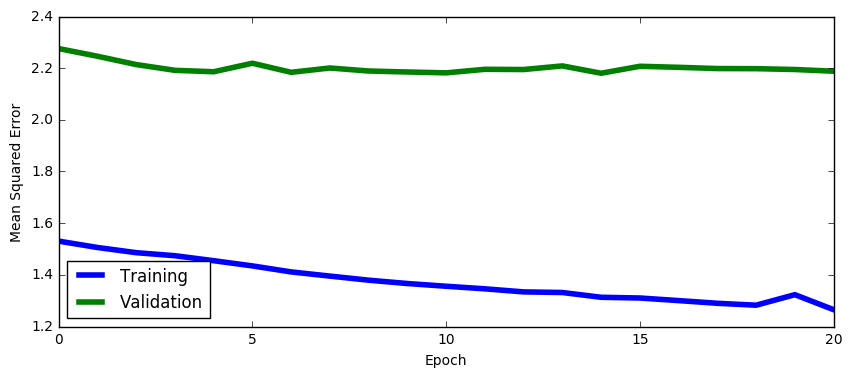

In [14]:
metric = "Mean Squared Error"
print_loss(multi_filter_model, metric)